# **Module 7 Final Project Notebook - Group 28**

## **Huffington Post News Category Predictions**

Our final project consists of a multi-label classification task performed on the HuffPost News Category dataset. Each of the (approx.) 200,000 records in our dataset contains a headline, a short description, and other information and is labeled with one of 41 different class labels.

Our job is to build a pipeline that can automatically assign an article to a given category given a headline and a short description. This task has a variety of useful applications from automatic labeling of text based social media posts, categorization of other news articles, screening a variety of news sources and aggregating by category (as done in aggregators like Ground News) and so on.

In this notebook we will import the raw data, discuss any decisions we made about cleaning and pre-processing the data, then train and test our final model to completion. Additionally, we will discuss our architectural choises in modeling and walk through our various experiments that led to our final prediction.

#### **Useful Package Imports**

In [ ]:
# Standard Stuff
import os
import time
import random
from collections import Counter
from tqdm import tqdm

# Data Processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# NLP / Tokenization
import spacy

# TensorFlow / Keras (Deep Learning)
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers, models, Input, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, MaxPooling2D, Conv2D,
    SeparableConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
)
import keras_hub as kh
from tensorflow import keras

# SK Learn Imports
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score, accuracy_score



# Global Regularization and Utilities
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.keras.utils.set_random_seed(SEED)   # sets Python, NumPy, and TensorFlow seeds


# Further Utility Function for time tracking:
def format_hms(seconds: float) -> str:
    """Convert seconds to HH:MM:SS format."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

### **Import Datasets**

And from here, we will import our dataset, starting with the hugging face imports:

In [ ]:
from datasets import load_dataset, DatasetDict
from datasets.features import ClassLabel

And the dataset itself from a JSON Mirror:

In [ ]:
# JSON mirror that preserves fields: headline, short_description, category, authors, link, date
URL = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"
huff_all = load_dataset("json", data_files=URL, split="train")

# And a quick print of heuristics
print(f"HuffPost Columns: {huff_all.column_names}")
print(f"Total rows: {len(huff_all):,}")

# And then we'll convert it to a DataFrame for the rest of the pipeline
df = huff_all.to_pandas()
df = df[["headline","short_description","category","authors","link","date"]].copy()
df_eda = df.copy()

HuffPost Columns: ['category', 'headline', 'authors', 'link', 'short_description', 'date']
Total rows: 200,853


___

# **Dataset Cleaning and Pre-Processing:**

From here, we'll clean and process a number of issues that were identified in Milestone 1. Regarding the pre-processing we will drop columns like author, link, and date as they are not part of this classification task. Then we'll concatenate the headline and short description together to act as our model features, and retain the 'category' column to act as our target.

**Preprocessing**

Here, the we'll utilize a clean_text function to return an empty string (if null or N/A); trim any leading or trailing whitespaces; normalize any internal white spaces to be in the format of " ", and then return all lower cases.

 For example, **" Lorem\nIpsum ..." will become: "lorem ipsum ..."**

In [ ]:
def clean_text(s):
    if not isinstance(s, str):
        return ""
    s = s.strip().lower()
    return " ".join(s.split())

# Concatenate headline + summary, then clean
text = (df["headline"].fillna("") + " " + df["short_description"].fillna("")).apply(clean_text)

**Data Cleaning**

Here we will remove blank rows, drop any duplicates, and then format our category columns to remove any weird strings.

In [ ]:
# Remove any empty samples
mask_nonempty = text.str.len() > 0
df = df.loc[mask_nonempty].copy()
df["text"] = text[mask_nonempty].values

# Drop any Duplicates (and count dropped rows for record keeping)
before = len(df)
df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)
after = len(df)
print(f"Removed {before - after} duplicate rows; remaining = {after}")


# Format category columns to ameliorate any weird strings
df["category"] = (
    df["category"]
    .fillna("")
    .str.strip()
    .str.upper()
    .str.replace("’", "'", regex=False)
    .str.replace(r"\s+", " ", regex=True)
)


Removed 492 duplicate rows; remaining = 200356


And here we will apply our data-cleaning step to consolidate any categories that were identified in Milestone 1 as having a high lexical overlap (as revealed by Jaccard similarity). After this, we returned to this step to revisit consolidating categories with a high *semantic* overlap in terms of subject matter subsequent to the second milestone. (The details of which are discussed in APPENDIX A).

NOTE: As we'll discuss later, there were several rounds of this after maximizing the amount of performance we could get from architectural / and training regimine changes alone. The label consolidations are organized by category, and denoted with labels corresponding to the round in which they were added.

#### **Label Consolidation**

In [ ]:
# Consolidate Classes from Milestone 1
map_to = {
    # Arts & Entertainment
    "ARTS": "ARTS & ENTERTAINMENT",
    "ARTS & CULTURE": "ARTS & ENTERTAINMENT",
    "CULTURE & ARTS": "ARTS & ENTERTAINMENT",
    "ENTERTAINMENT": "ARTS & ENTERTAINMENT",

    # Health & Wellness
    "WELLNESS": "HEALTH & WELLNESS",
    "HEALTHY LIVING": "HEALTH & WELLNESS",
    "FIFTY": "HEALTH & WELLNESS",            # ADDED AFTER SECOND ROUND - This relates to living after 50

    # Food & Drink
    "FOOD & DRINK": "FOOD & DRINK",
    "FOOD & DRINK.": "FOOD & DRINK",
    "TASTE": "FOOD & DRINK",

    # Family & Relationships
    "PARENTING": "FAMILY & RELATIONSHIPS",
    "PARENTS": "FAMILY & RELATIONSHIPS",
    "DIVORCE": "FAMILY & RELATIONSHIPS",
    "WEDDINGS": "FAMILY & RELATIONSHIPS",

    # World News
    "WORLDPOST": "WORLD NEWS",
    "THE WORLDPOST": "WORLD NEWS",

    # Environment
    "GREEN": "ENVIRONMENT",

    # Business & Money
    "BUSINESS": "BUSINESS & MONEY",
    "MONEY": "BUSINESS & MONEY",

    # Education
    "COLLEGE": "EDUCATION",

    # Regarding Voices and Identity
    "BLACK VOICES": "VOICES & IDENTITY",          # ADDED AFTER SECOND ROUND [Appendix A]
    "LATINO VOICES": "VOICES & IDENTITY",         # ADDED AFTER SECOND ROUND [Appendix A]
    "QUEER VOICES": "VOICES & IDENTITY",          # ADDED AFTER SECOND ROUND [Appendix A]
    "WOMEN": "VOICES & IDENTITY",                                                       # ADDED AFTER THIRD ROUND [Appendix A]



    # 'Other' Categories
    "GOOD NEWS": "OTHER NEWS",                  # ADDED AFTER SECOND ROUND - semantically more similar than Arts and Culture and Culture and Arts - [Appendix A]
    "WEIRD NEWS": "OTHER NEWS",                 # ADDED AFTER SECOND ROUND - [Appendix A]

    # Tried this one but it resulted in worse model performance [Appendix A]
    # "STYLE": "STYLE & BEAUTY"
}


# Replace using the mapping, leave others untouched
df["label_str"] = df["category"].replace(map_to)

df = df[["text","label_str","authors","link","date"]]


# Experiment 8 - Temp Drop Impact ====================
df_no_impact = df[df["label_str"]!="IMPACT"].copy()
df_impact   = df[df["label_str"]=="IMPACT"].copy()

# Temp omit impact (we'll use model to re-classify and then go later)
df = df_no_impact

# End Experiment 8 ==================================

df.head(3)

,text,label_str,authors,link,date
0,there were 2 mass shootings in texas last week...,CRIME,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,2018-05-26
1,will smith joins diplo and nicky jam for the 2...,ARTS & ENTERTAINMENT,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,2018-05-26
2,hugh grant marries for the first time at age 5...,ARTS & ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,2018-05-26


At this point, as a sanity check, we printed out the Categories along with the aggregated amount of records for each after the label consolidation. This was meant to give us a quick look at how many categories were left after consolidation  (from the original 41), as well as the new relative class imbalance.

In [ ]:
print(f"Unique labels (after consolidation): {len(df["label_str"].unique())}\n")
print(df["label_str"].value_counts().head(25))

# And quick double check that we got all of the empty rows
print("\n Any empty texts left? ", (df["text"].str.len()==0).sum())

Unique labels (after consolidation): 22

label_str
POLITICS                  32721
HEALTH & WELLNESS         25911
ARTS & ENTERTAINMENT      19930
FAMILY & RELATIONSHIPS    19618
VOICES & IDENTITY         15366
TRAVEL                     9883
STYLE & BEAUTY             9512
WORLD NEWS                 8418
FOOD & DRINK               8320
BUSINESS & MONEY           7639
COMEDY                     5163
SPORTS                     4884
HOME & LIVING              4161
OTHER NEWS                 4068
ENVIRONMENT                3939
CRIME                      3401
MEDIA                      2812
RELIGION                   2548
STYLE                      2246
SCIENCE                    2178
EDUCATION                  2148
TECH                       2033
Name: count, dtype: int64

 Any empty texts left?  0


And next, we'll pre process our target by taking the unique categories, alphabetizing them, and and then doing some integer encoding to get them to play nicely with our Transformer.

In [ ]:
# Alphabetize
cats = sorted(df["label_str"].unique())

# Encode Categories
cat2id = {c:i for i,c in enumerate(cats)}
id2cat = {i:c for c,i in cat2id.items()}
df["label"] = df["label_str"].map(cat2id).astype(int)

And here, we'll include the logic for training subsets of the dataset to cut down on computation costs during our experiments. (It's set to 100% for the final run).

In [ ]:
# Our running percentage of the dataset we're training on
SUBSET_FRAC = 1.0

# splits the dataset using SK learns traintest split
if 0.0 < SUBSET_FRAC < 1.0:
    df_pool, _ = train_test_split(
        df,
        train_size=SUBSET_FRAC,
        random_state=SEED,
        stratify=df["label"],
    )
else:
    df_pool = df

# And sanity check prints
print(f"Pool after SUBSET_FRAC={SUBSET_FRAC}: {len(df_pool)} (of {len(df)})")
print("Label distribution in pool (first 10):")
print(df_pool["label"].value_counts().head(10))

Pool after SUBSET_FRAC=1.0: 196899 (of 196899)
Label distribution in pool (first 10):
label
12    32721
8     25911
0     19930
6     19618
20    15366
19     9883
17     9512
21     8418
7      8320
1      7639
Name: count, dtype: int64


#### **Feature Padding and Vectorization Setup**

And then we'll tokenize and pad our features to prepare them for our Neural Net. The decision to go with the 95th percentile is dicussed in Appendix A.

In [ ]:
# First Tokenize, and then get a feel for the counts
token_counts = df["text"].str.split().apply(len)
p95 = int(np.percentile(token_counts, 95))

# Apply a length cap at about the 95th percentile of tokens.
MAX_TOKENS = 30000
# MAX_LENGTH = max(16, min(96, p95))  # This comes out to be around 56 tokens per record
MAX_LENGTH = 128

print(f"Classes: {len(cats)} | MAX_TOKENS={MAX_TOKENS} | p95={p95} → MAX_LENGTH={MAX_LENGTH}")
print(df["label_str"].value_counts().head(10))


Classes: 22 | MAX_TOKENS=30000 | p95=55 → MAX_LENGTH=128
label_str
POLITICS                  32721
HEALTH & WELLNESS         25911
ARTS & ENTERTAINMENT      19930
FAMILY & RELATIONSHIPS    19618
VOICES & IDENTITY         15366
TRAVEL                     9883
STYLE & BEAUTY             9512
WORLD NEWS                 8418
FOOD & DRINK               8320
BUSINESS & MONEY           7639
Name: count, dtype: int64


Now we can train-test split our dataset using an 80 / 10 / 10 split for training, validation, and testing in TensorFlow.

In [ ]:
# Stratified 80/10/10 splits

# filter DF to just our features and target
X = df["text"].values
y = df["label"].values

# Train vs temp (later split into val and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

# Split the Temp into Val and Test 50/50
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

print(f"Train/Val/Test sizes: {len(X_train)} / {len(X_val)} / {len(X_test)}")

Train/Val/Test sizes: 157519 / 19690 / 19690


#### **Class Weighting**

Here, because our dataset is extremely unbalanced, we'll create a class weight dictionary to make up for the fact that some categories have 16 times as many records as others

In [ ]:
classes = np.arange(len(cats))

# Apply SKlearn's balanced class weights
cw_arr = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
CLASS_WEIGHTS = {int(c): float(w) for c, w in zip(classes, cw_arr)}
list(CLASS_WEIGHTS.items())[:10]

[(0, 0.4490689002417552),
 (1, 1.1716502283512593),
 (2, 1.733645168390931),
 (3, 2.6313688149410313),
 (4, 4.16518589031678),
 (5, 2.27228008424454),
 (6, 0.4562224127344556),
 (7, 1.0757143247377623),
 (8, 0.3454076195404769),
 (9, 2.1507823807313144)]

And next, we'll do a final preparation for our dataset to go into our BERT pre-processing layer. It will intake our training and validation data and turn it into lists of tuple pairs of featues (string) and target (integer).

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_BERT = 32

# prepare the tuple (input "text", output label structure)
def make_ds_bert(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(10_000, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_BERT, drop_remainder=False)
    # Match the model input name: "text"
    ds = ds.map(lambda x, y: ({"text": x}, y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

# apply function to our training and validation splits
ds_train_bert = make_ds_bert(X_train, y_train, shuffle=True)
ds_val_bert   = make_ds_bert(X_val,   y_val,   shuffle=False)
ds_test_bert = make_ds_bert(X_test, y_test, shuffle=False)


# sanity Check
for xb, yb in ds_train_bert.take(1):
    print(xb.keys())          # should be: dict_keys(['text'])
    print(xb["text"].shape)   # (batch_size,)
    print(xb["text"].dtype)   # string
    print(yb.shape, yb.dtype) # (batch_size,), int32

dict_keys(['text'])
(32,)
<dtype: 'string'>
(32,) <dtype: 'int64'>


____

# **Modeling**

#### **Architecture**

For our modeling, we chose to go with a pre-trained Distil-BERT model with a custom head architecture as detailed below. This architecture was settled on by conducting a number of different experiements, the results of which are in Appendix A.

**Base Model**

- Distil-BERT

(Forgo Bert's Built-In classification and use our own)

**Custom Classification Head**

- 1028 Dense layer (ReLu) Activation
    - Dropout (0.3)
- 512 Dense layer (ReLu) Activation
    - Dropout (0.3)
- 256 Dense layer (ReLu) Activation




In [ ]:
# Quick Pulls from Earlier

NUM_CLASSES = len(cats) # Number of Categories post Cleaning
MAX_LEN     = MAX_LENGTH # Hard Cap on token length (from our 95% earlier)


# Distill BERT Pipeline
preproc  = kh.models.DistilBertTextClassifierPreprocessor.from_preset(
    "distil_bert_base_en_uncased", sequence_length=MAX_LEN
)
pipeline = kh.models.DistilBertTextClassifier.from_preset(
    "distil_bert_base_en_uncased", num_classes=NUM_CLASSES, preprocessor=preproc
)


# Model Inputs
text_in  = keras.Input(shape=(), dtype="string", name="text") # Input Raw Strings of MAX_LEN (our 95%)
tokens   = preproc(text_in)

backbone = pipeline.get_layer("distil_bert_backbone")
backbone.trainable = True    # We'll change this later

seq_out  = backbone(tokens)       # Bert output (B, T, 768)

# Bypass Bert's Classification Layer and use our own head instead
cls    = layers.Lambda(lambda t: t[:, 0, :], name="cls")(seq_out)

# Our Custom Classification Head
x      = layers.Dense(1028, activation="relu")(cls)
x      = layers.Dropout(0.3)(x)
x      = layers.Dense(512, activation="relu")(x)
x      = layers.Dropout(0.3)(x)
x      = layers.Dense(256, activation="relu")(x)

logits = layers.Dense(NUM_CLASSES, activation=None, name="logits")(x)

# Name it to call for summary later
bertinator = keras.Model(text_in, logits, name="distilbert_strin_custom")

# And summarize
bertinator.summary()

Model: "distilbert_strin_custom"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_text_c… │ [(None, 128),     │          0 │ text[0][0]        │
│ (DistilBertTextCla… │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_backbo… │ (None, 128, 768)  │ 66,362,880 │ distil_bert_text… │
│ (DistilBertBackbon… │                   │            │ distil_bert_text… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls (Lambda)        │ (None, 768)       │          0 │ distil_bert_back… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1028)      │    790,532 │ cls[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 1028)      │          0 │ dense_9[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 512)       │    526,848 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 512)       │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │    131,328 │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits (Dense)      │ (None, 22)        │      5,654 │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,817,242 (258.70 MB)

 Trainable params: 67,817,242 (258.70 MB)

 Non-trainable params: 0 (0.00 B)

#### **Training Strategies**

Because our dataset consists of a pre-trained transformer with a custom classification head, and in order to take care of any vanishing gradient issues,  we will split training up into two rounds.

For the first round, we'll freeze the backbone and only train the classification head. To prevent overfitting, we'll only do this for 3 epochs. Then during a second round of training, we'll unfreeze the backbone of the pre-trained model, and train the whole network together.

Again this strategy was a result of experiments detailed in Appendix A.

**First Round Training**


In [ ]:
# Compile the Bert Backbone - This time, we compile it as frozen with a high LR
backbone.trainable = False                                           # Frozen :)
bertinator.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),             # High LR this time (for the head)
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    jit_compile=False,
)


# Start Training Timer
start = time.time()

# We'll hard cap the epochs at 3 this time (and will train more later)
EPOCHS = 3

# We'll also use Early Stopping as a failsafe to prevent overfitting
# (even though that's not expected with only 3 epochs this round)
cb = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)]


history = bertinator.fit(
    ds_train_bert,
    validation_data=ds_val_bert,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHTS,       # Use our class weights from Earlier
    callbacks=cb,                     # Only early stopping as it's a warm up
    verbose=2,                        # Setting verbose to 2 to cut down on Colab log spam
)

print(f"Elapsed Time: {(time.time()-start)/60:.2f} min")

Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: text
Received: inputs=['Tensor(shape=(None,))']
  warnings.warn(msg)


4923/4923 - 117s - 24ms/step - accuracy: 0.4781 - loss: 1.6771 - val_accuracy: 0.5853 - val_loss: 1.3932
Epoch 2/3
4923/4923 - 105s - 21ms/step - accuracy: 0.5299 - loss: 1.5021 - val_accuracy: 0.5766 - val_loss: 1.3965
Epoch 3/3
4923/4923 - 105s - 21ms/step - accuracy: 0.5408 - loss: 1.4552 - val_accuracy: 0.5581 - val_loss: 1.4617
Elapsed Time: 5.44 min


**Second Round Training:**

This time we will re-compile with an *unfrozen* backbone and a lower baseline learning rate and then we will train for a maximum of 6 more rounds. Throughout the course of our experiments, we tried several different setups and settled on the following methodology:


- Hard Cap of 6 epochs (this round) this was originally lower, but the model training was consistantly using all available training rounds.

*Callbacks*
- Early stopping to prevent overfitting (if no improvement stop early)
- Reduce on Plateau again to dial back the learning rate and reduce overfitting as we've already trained the classification head in isolation.



In [ ]:
# Re-Compile wiht an unfrozen backbone this time
backbone.trainable = True

bertinator.compile(
    optimizer=keras.optimizers.Adam(2e-5), # lower starting LR this time to prevent overfitting
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
    jit_compile=False
)

# And fit a second time
start = time.time()

# Bumped the max up to 6 epochs this round
EPOCHS = 6

# Callbacks - Same early stopping as before but with Reduce on Pleateau this time
# (as an extra fail safe)
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=1,
    min_lr=1e-6,
    verbose=1,
)

# Same overall as before, just wiht a list of callbacks this time
history_ft = bertinator.fit(
    ds_train_bert,
    validation_data=ds_val_bert,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    class_weight=CLASS_WEIGHTS
)

print(f"Elapsed Time: {(time.time()-start)/60:.2f} min")

Epoch 1/6
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 379s 73ms/step - accuracy: 0.6066 - loss: 1.2668 - val_accuracy: 0.6810 - val_loss: 1.0714 - learning_rate: 2.0000e-05
Epoch 2/6
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 358s 73ms/step - accuracy: 0.6928 - loss: 0.9163 - val_accuracy: 0.6959 - val_loss: 1.0149 - learning_rate: 2.0000e-05
Epoch 3/6
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 357s 73ms/step - accuracy: 0.7347 - loss: 0.7241 - val_accuracy: 0.7183 - val_loss: 0.9686 - learning_rate: 2.0000e-05
Epoch 4/6
4922/4923 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7727 - loss: 0.5701
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 357s 72ms/step - accuracy: 0.7727 - loss: 0.5701 - val_accuracy: 0.7271 - val_loss: 0.9825 - learning_rate: 2.0000e-05
Epoch 5/6
4922/4923 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8116 - loss: 0.4287
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 357s 73ms/s

## **Training Results and Discussion**

To visualize our results, we will first re-use two visualization functions from our second milestone here. The first one plots training vs. validation loss throughout the training process, and the second one plots training vs. validation *accuracy* as the training epochs progressed.

In [ ]:
def plot_history_loss(history, title_suffix=""):
    plt.figure()
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("loss"); plt.title(f"Training vs Validation loss {title_suffix}".strip())
    plt.legend(); plt.show()


def plot_history(history, key="acc", title_suffix=""):
    train_key = next((k for k in history.history.keys() if k in (key, f"train_{key}", "acc", "accuracy")), None)
    val_key   = next((k for k in history.history.keys() if k in (f"val_{key}", "val_acc", "val_accuracy")), None)
    assert train_key and val_key, f"Keys not found in history: {list(history.history.keys())}"
    plt.figure()
    plt.plot(history.history[train_key], label=f"train_{key}")
    plt.plot(history.history[val_key],   label=f"val_{key}")
    plt.xlabel("Epoch"); plt.ylabel(key); plt.title(f"Training vs Validation {key} {title_suffix}".strip())
    plt.legend(); plt.show()


Here is a look at the validation loss

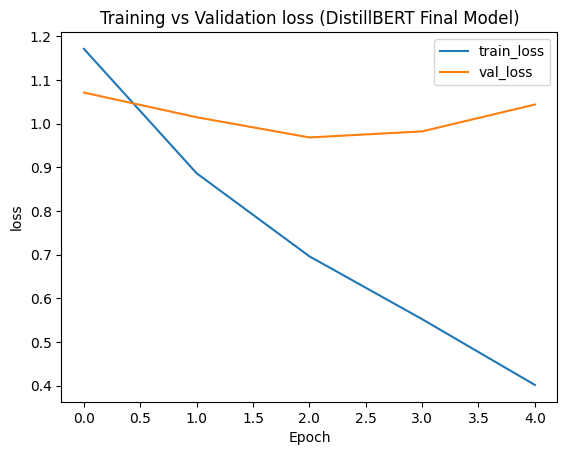

In [ ]:
plot_history_loss(history_ft, title_suffix="(DistillBERT Final Model)")

And here is the validation accuracy: 

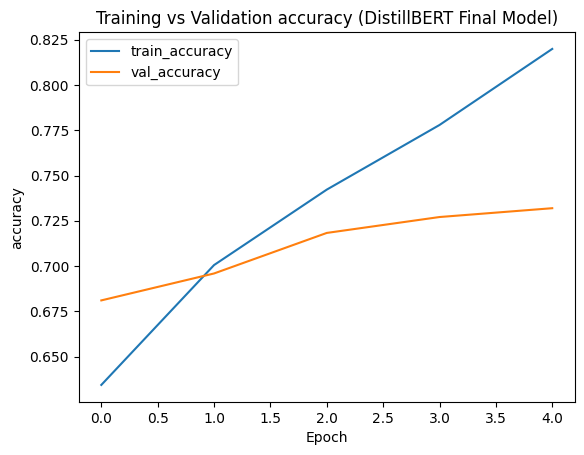

In [ ]:
plot_history(history_ft, key="accuracy", title_suffix="(DistillBERT Final Model)")

## **Overall Results of Pre-Trained Model**

In [ ]:
model =  bertinator

EVAL_BATCH = 32

logits_or_probs = model.predict(
    {"text": X_test},
    batch_size=EVAL_BATCH,
    verbose=0
)

y_pred = np.argmax(logits_or_probs, axis=-1)

y_true = np.asarray(y_test)
test_acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")

print(f"\n[Experiment 9] Drop Impact Pre-Train Accuracy: {test_acc:.4f} | Macro F1: {macro_f1:.4f}\n")
print(classification_report(
    y_true, y_pred,
    target_names=[id2cat[i] for i in range(NUM_CLASSES)],
    digits=3
))


[Experiment 9] Drop Impact Pre-Train Accuracy: 0.7701 | Macro F1: 0.7434

                        precision    recall  f1-score   support

  ARTS & ENTERTAINMENT      0.848     0.681     0.755      2000
      BUSINESS & MONEY      0.683     0.696     0.690       807
                COMEDY      0.540     0.671     0.598       519
                 CRIME      0.600     0.888     0.716       347
             EDUCATION      0.490     0.887     0.631       240
           ENVIRONMENT      0.638     0.856     0.731       418
FAMILY & RELATIONSHIPS      0.859     0.799     0.828      1982
          FOOD & DRINK      0.843     0.926     0.883       837
     HEALTH & WELLNESS      0.893     0.729     0.803      2641
         HOME & LIVING      0.801     0.952     0.870       419
                 MEDIA      0.495     0.870     0.631       284
            OTHER NEWS      0.648     0.761     0.700       422
              POLITICS      0.920     0.680     0.782      3291
              RELIGION      

# **Re-Classification of the Impact Category using Our Pre-Trained Model**

We already seperated out our df_impact (just 'Impact' stories) from the rest of our dataframe before training, and it's beimg stored as a data_frame. Now the idea is to use our newly trained pre-model to re-classify this category as other categories, and then contatenate those back onto df_no_impact, and then re-train a fresh BERT model on the result.

First let's prep our DF for input into our model

In [ ]:
# strip the 'text' features and create some dummy target (0's array)
# and then we'll pair that with our make_ds_bert() function from earlier.

x_impact = df_impact["text"].astype(str).values
y_dummy_impact = np.zeros(len(x_impact), dtype='int32')

# Now make our model inputs
ds_impact_bert = make_ds_bert(x_impact, y_dummy_impact, shuffle=False)

And now let's get class predictions for our 'IMPACT' articles:

In [ ]:
pred_ids_list = []


for xb, _ in ds_impact_bert:                     # xb is {"text": batch_of_strings}
    logits = bertinator(xb, training=False)      # shape: (batch, num_classes_without_impact)
    batch_pred_ids = np.argmax(logits.numpy(), axis=-1)
    pred_ids_list.append(batch_pred_ids)

y_pred_impact = np.concatenate(pred_ids_list, axis=0)  # shape: (N_impact,)

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: text
Received: inputs=['Tensor(shape=(32,))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: text
Received: inputs=['Tensor(shape=(1,))']
  warnings.warn(msg)


Now we'll reverse-map our predicted values (because remember BERT predicts integers like 1,2,3, etc. to our original label strings using our original id2cat encoder.

In [ ]:
# Use our id2cat in a list comp to map back to string labels
pred_labels_str = [id2cat[i] for i in y_pred_impact]

# assign back to df_impact data frame
df_impact['label'] = y_pred_impact
df_impact['label_str'] = pred_labels_str

# And let's view a few as a sanity check
df_impact[['text', 'label_str']].head(5)

,text,label_str
12,"with its way of life at risk, this remote oyst...",TECH
66,monsanto and bayer are set to merge. here's wh...,BUSINESS & MONEY
125,you're going to use that self-checkout machine...,BUSINESS & MONEY
193,machines don't always steal our jobs. increasi...,TECH
286,she started a suicide prevention site at age 1...,HEALTH & WELLNESS


Yep, that's passing the sniff test -- let's append this back onto the original df that we took the 'Impact' category OUT of so that our data is whole again.

In [ ]:
df_reclassified = pd.concat([df_no_impact, df_impact], ignore_index=True)

# And we'll sanity check that the IMPACT category no longer exists
# this SHOULD be empty
df_reclassified[df_reclassified['label_str'].str.contains("IMPACT")].head(5)

,text,label_str,authors,link,date,label


Cool, now we can just run everything in our pipeline that is downstream of this point to train a new model, son_of_bertinator the same way we trained the old one.




First, let's check our sanity checks from before again on our new-and-improved input data to make sure our efforts are still grounded in reality.

In [ ]:
print(f"Unique labels (after consolidation): {len(df_reclassified["label_str"].unique())}\n")
print(df_reclassified["label_str"].value_counts().head(25))

# And quick double check that we got all of the empty rows
print("\n Any empty texts left? ", (df_reclassified["text"].str.len()==0).sum())

Unique labels (after consolidation): 22

label_str
POLITICS                  32904
HEALTH & WELLNESS         26406
ARTS & ENTERTAINMENT      19997
FAMILY & RELATIONSHIPS    19814
VOICES & IDENTITY         15674
TRAVEL                     9967
STYLE & BEAUTY             9520
WORLD NEWS                 8833
FOOD & DRINK               8370
BUSINESS & MONEY           8076
COMEDY                     5187
SPORTS                     4960
OTHER NEWS                 4225
HOME & LIVING              4191
ENVIRONMENT                4177
CRIME                      3476
MEDIA                      2842
RELIGION                   2678
EDUCATION                  2406
STYLE                      2272
SCIENCE                    2242
TECH                       2139
Name: count, dtype: int64

 Any empty texts left?  0


Because this new df_reclassified dataset has passed all of our tests, at this point we will re-assign it to the variable name 'df' and re-run our pipeline up to this point.

Now that our other categories have been augmented with our originally 'IMPACT' rows, we're clear to re-run our pipeline. To be safe, we will re-run everything downstream of the 'Impact' spin off.

So first, re-assignment:

In [ ]:
df = df_reclassified

And now, we will re-run the pipeline from this point, re-naming the Model and the History objects to make sure we don't accidentally re-train the same thing.

In [ ]:
cats = sorted(df["label_str"].unique())

# Encode Categories
cat2id = {c:i for i,c in enumerate(cats)}
id2cat = {i:c for c,i in cat2id.items()}
df["label"] = df["label_str"].map(cat2id).astype(int)

Now, re-tokenization:

In [ ]:
# First Tokenize, and then get a feel for the counts
token_counts = df["text"].str.split().apply(len)
p95 = int(np.percentile(token_counts, 95))

# Apply a length cap at about the 95th percentile of tokens.
MAX_TOKENS = 30000
# MAX_LENGTH = max(16, min(96, p95))  # This comes out to be around 56 tokens per record
MAX_LENGTH = 128

print(f"Classes: {len(cats)} | MAX_TOKENS={MAX_TOKENS} | p95={p95} → MAX_LENGTH={MAX_LENGTH}")
print(df["label_str"].value_counts().head(10))

Classes: 22 | MAX_TOKENS=30000 | p95=56 → MAX_LENGTH=128
label_str
POLITICS                  32904
HEALTH & WELLNESS         26406
ARTS & ENTERTAINMENT      19997
FAMILY & RELATIONSHIPS    19814
VOICES & IDENTITY         15674
TRAVEL                     9967
STYLE & BEAUTY             9520
WORLD NEWS                 8833
FOOD & DRINK               8370
BUSINESS & MONEY           8076
Name: count, dtype: int64


And now, we will re-split our data with our augmented categories:

In [ ]:
# Stratified 80/10/10 splits

# filter DF to just our features and target
X = df["text"].values
y = df["label"].values

# Train vs temp (later split into val and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

# Split the Temp into Val and Test 50/50
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

print(f"Train/Val/Test sizes: {len(X_train)} / {len(X_val)} / {len(X_test)}")

Train/Val/Test sizes: 160284 / 20036 / 20036


And re-compute our class weights as the re-assignment has changed the relative class balances.

In [ ]:
classes = np.arange(len(cats))

# Apply SKlearn's balanced class weights
cw_arr = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
CLASS_WEIGHTS = {int(c): float(w) for c, w in zip(classes, cw_arr)}
list(CLASS_WEIGHTS.items())[:10]



# The output is our integer labels from cat2id, and then a class weight
# to help with classification

[(0, 0.4554376672898896),
 (1, 1.1276329304498318),
 (2, 1.7559981594688754),
 (3, 2.619790134353241),
 (4, 3.784746162927981),
 (5, 2.1800228496817367),
 (6, 0.45963260132713163),
 (7, 1.088057999348322),
 (8, 0.3448821947283486),
 (9, 2.172870970365751)]

And now we will re-prepare it for intake into BERT's pre-processing layer.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_BERT = 32

# prepare the tuple (input "text", output label structure)
def make_ds_bert(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(10_000, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_BERT, drop_remainder=False)
    # Match the model input name: "text"
    ds = ds.map(lambda x, y: ({"text": x}, y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

# apply function to our training and validation splits
ds_train_bert = make_ds_bert(X_train, y_train, shuffle=True)
ds_val_bert   = make_ds_bert(X_val,   y_val,   shuffle=False)
ds_test_bert = make_ds_bert(X_test, y_test, shuffle=False)


# sanity Check
for xb, yb in ds_train_bert.take(1):
    print(xb.keys())          # should be: dict_keys(['text'])
    print(xb["text"].shape)   # (batch_size,)
    print(xb["text"].dtype)   # string
    print(yb.shape, yb.dtype) # (batch_size,), int32

dict_keys(['text'])
(32,)
<dtype: 'string'>
(32,) <dtype: 'int64'>


# **Modeling with Augmented Categories**

Here we will run our pipeline using the same architecture as before, only this time, we will run it with our augmented categories. The only meaningful difference here will be the re-naming of the model itself so that we do not re-train the model from earlier.

In [ ]:
# Quick Pulls from Earlier

NUM_CLASSES = len(cats) # Number of Categories post Cleaning
MAX_LEN     = MAX_LENGTH # Hard Cap on token length (from our 95% earlier)


# Distill BERT Pipeline
preproc  = kh.models.DistilBertTextClassifierPreprocessor.from_preset(
    "distil_bert_base_en_uncased", sequence_length=MAX_LEN
)
pipeline = kh.models.DistilBertTextClassifier.from_preset(
    "distil_bert_base_en_uncased", num_classes=NUM_CLASSES, preprocessor=preproc
)


# Model Inputs
text_in  = keras.Input(shape=(), dtype="string", name="text") # Input Raw Strings of our MAX_LENGTH set from earlier
tokens   = preproc(text_in)

backbone = pipeline.get_layer("distil_bert_backbone")
backbone.trainable = True    # Again, we'll change this later

seq_out  = backbone(tokens)       # Bert output (B, T, 768)

# Bypass Bert's Classification Layer and use our own head instead -- again
cls    = layers.Lambda(lambda t: t[:, 0, :], name="cls")(seq_out)

# Our (same) Custom Classification Head
x      = layers.Dense(1028, activation="relu")(cls)
x      = layers.Dropout(0.3)(x)
x      = layers.Dense(512, activation="relu")(x)
x      = layers.Dropout(0.3)(x)
x      = layers.Dense(256, activation="relu")(x)

logits = layers.Dense(NUM_CLASSES, activation=None, name="logits")(x)

# Name it to call for summary later
son_of_bertinator = keras.Model(text_in, logits, name="distilbert_strin_custom")

# And summarize
son_of_bertinator.summary()

100%|██████████| 462/462 [00:00<00:00, 866kB/s]


100%|██████████| 794/794 [00:00<00:00, 1.10MB/s]


Model: "distilbert_strin_custom"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_text_c… │ [(None, 128),     │          0 │ text[0][0]        │
│ (DistilBertTextCla… │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_backbo… │ (None, 128, 768)  │ 66,362,880 │ distil_bert_text… │
│ (DistilBertBackbon… │                   │            │ distil_bert_text… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls (Lambda)        │ (None, 768)       │          0 │ distil_bert_back… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1028)      │    790,532 │ cls[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 1028)      │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 512)       │    526,848 │ dropout_38[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 512)       │          0 │ dense_13[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │    131,328 │ dropout_39[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits (Dense)      │ (None, 22)        │      5,654 │ dense_14[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,817,242 (258.70 MB)

 Trainable params: 67,817,242 (258.70 MB)

 Non-trainable params: 0 (0.00 B)

And now, we will implement the same multi-tiered training strategy we implemented before.
- Step 1: Freeze the backbone - Train the classification head
- Step 2: Un-Freeze the backbone - Train the Underlying Transformer

In [ ]:
# Compile the Bert Backbone - This time, we compile it as frozen with a high LR
backbone.trainable = False                                           # Frozen :)


# And make sure we compile the NEW model
son_of_bertinator.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),             # High LR this time (for the head)
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    jit_compile=False,
)


# Start Training Timer
start = time.time()

# We'll hard cap the epochs at 3 this time (and will train more later)
EPOCHS = 3

# We'll also use Early Stopping as a failsafe to prevent overfitting
# (even though that's not expected with only 3 epochs this round)
cb = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)]


pre_history = son_of_bertinator.fit(      # < - Changing the model name here to the new value
    ds_train_bert,
    validation_data=ds_val_bert,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHTS,       # Use our class weights from Earlier
    callbacks=cb,                     # Only early stopping as it's a warm up
    verbose=2,                        # Setting verbose to 2 to cut down on Colab log spam
)

print(f"Elapsed Time: {(time.time()-start)/60:.2f} min")

Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: text
Received: inputs=['Tensor(shape=(None,))']
  warnings.warn(msg)


5009/5009 - 119s - 24ms/step - accuracy: 0.4773 - loss: 1.6782 - val_accuracy: 0.5514 - val_loss: 1.4882
Epoch 2/3
5009/5009 - 109s - 22ms/step - accuracy: 0.5305 - loss: 1.5027 - val_accuracy: 0.5732 - val_loss: 1.3913
Epoch 3/3
5009/5009 - 106s - 21ms/step - accuracy: 0.5382 - loss: 1.4647 - val_accuracy: 0.5891 - val_loss: 1.3579
Elapsed Time: 5.57 min


And from here, we will implement the same structure for the second round of training, where we un-freeze the backbone and train the underlying transformer.

In [ ]:
# Re-Compile wiht an unfrozen backbone this time
backbone.trainable = True


# Again we need to re-compile it with an un-frozen backbone this time
son_of_bertinator.compile(
    optimizer=keras.optimizers.Adam(2e-5), # lower starting LR this time to prevent overfitting
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
    jit_compile=False
)

# And fit a second (or 4th? technically?) time
start = time.time()

# Bumped the max up to 6 epochs this round
EPOCHS = 6

# Callbacks - Same early stopping as before but with Reduce on Pleateau this time
# (as an extra fail safe)
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=1,
    min_lr=1e-6,
    verbose=1,
)

# Same overall as before, just wiht a list of callbacks this time
new_history_ft = son_of_bertinator.fit(                           # And we'll make sure to re-name our 'new' history object as well
    ds_train_bert,
    validation_data=ds_val_bert,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    class_weight=CLASS_WEIGHTS
)

print(f"Elapsed Time: {(time.time()-start)/60:.2f} min")

Epoch 1/6
5009/5009 ━━━━━━━━━━━━━━━━━━━━ 397s 75ms/step - accuracy: 0.6040 - loss: 1.2461 - val_accuracy: 0.6821 - val_loss: 1.0411 - learning_rate: 2.0000e-05
Epoch 2/6
5009/5009 ━━━━━━━━━━━━━━━━━━━━ 375s 75ms/step - accuracy: 0.6877 - loss: 0.9173 - val_accuracy: 0.7072 - val_loss: 0.9661 - learning_rate: 2.0000e-05
Epoch 3/6
5009/5009 ━━━━━━━━━━━━━━━━━━━━ 375s 75ms/step - accuracy: 0.7303 - loss: 0.7335 - val_accuracy: 0.7185 - val_loss: 0.9464 - learning_rate: 2.0000e-05
Epoch 4/6
5009/5009 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7638 - loss: 0.5976
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
5009/5009 ━━━━━━━━━━━━━━━━━━━━ 373s 75ms/step - accuracy: 0.7638 - loss: 0.5976 - val_accuracy: 0.7151 - val_loss: 0.9867 - learning_rate: 2.0000e-05
Epoch 5/6
5009/5009 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8007 - loss: 0.4539
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
5009/5009 ━━━━━━━━━━━━━━━━━━━━ 373s 75ms/s

## **Results of Model with Augmented Categories**

And let's find out how it did when we re-classified our IMPACT scores:

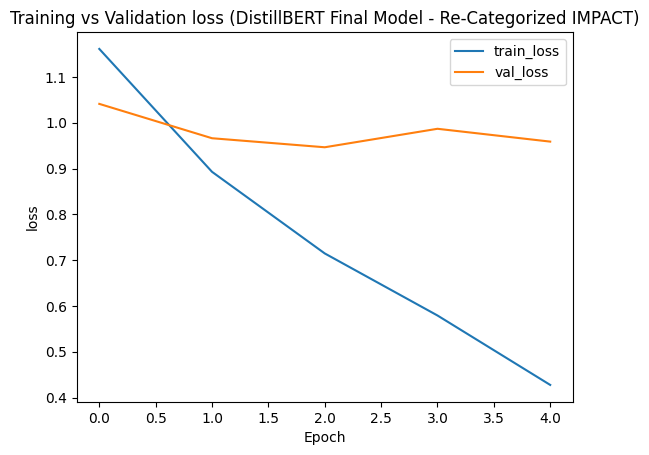

In [ ]:
plot_history_loss(new_history_ft, title_suffix="(DistillBERT Final Model - Re-Categorized IMPACT)")

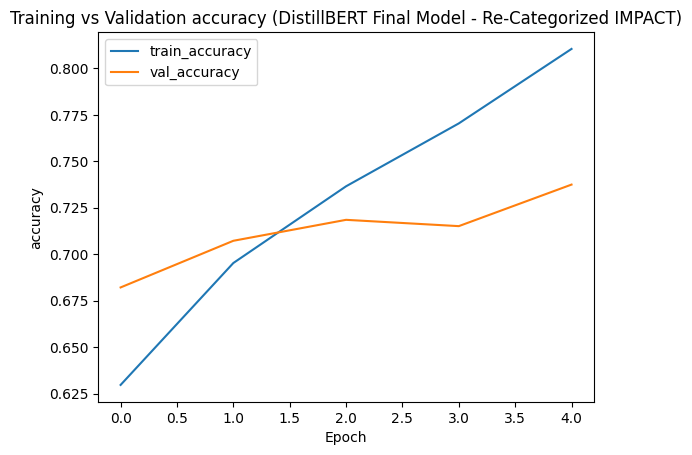

In [ ]:
plot_history(new_history_ft, key="accuracy", title_suffix="(DistillBERT Final Model - Re-Categorized IMPACT)")

In [ ]:
model =  son_of_bertinator

EVAL_BATCH = 32

logits_or_probs = model.predict(
    {"text": X_test},
    batch_size=EVAL_BATCH,
    verbose=0
)

y_pred = np.argmax(logits_or_probs, axis=-1)

y_true = np.asarray(y_test)
test_acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")

print(f"\n[Experiment 9] DistillBERT Final Model - Re-Categorized IMPACT: {test_acc:.4f} | Macro F1: {macro_f1:.4f}\n")
print(classification_report(
    y_true, y_pred,
    target_names=[id2cat[i] for i in range(NUM_CLASSES)],
    digits=3
))


[Experiment 9] DistillBERT Final Model - Re-Categorized IMPACT: 0.7129 | Macro F1: 0.6626

                        precision    recall  f1-score   support

  ARTS & ENTERTAINMENT      0.810     0.645     0.718      2000
      BUSINESS & MONEY      0.613     0.665     0.638       807
                COMEDY      0.513     0.636     0.568       519
                 CRIME      0.455     0.758     0.569       347
             EDUCATION      0.375     0.796     0.509       240
           ENVIRONMENT      0.485     0.720     0.579       418
FAMILY & RELATIONSHIPS      0.804     0.806     0.805      1982
          FOOD & DRINK      0.821     0.858     0.839       837
     HEALTH & WELLNESS      0.858     0.695     0.768      2641
         HOME & LIVING      0.742     0.874     0.803       419
                 MEDIA      0.440     0.768     0.560       284
            OTHER NEWS      0.501     0.552     0.525       422
              POLITICS      0.911     0.647     0.756      3291
           

_____

# **Appendix A**
### **Methodology and Experimental Discussion**

Here we discuss why decisions were made in each section, from pre-processing and label consolidation; to architecture and training regimine choices; as well as a detailed look at experimental findings post- milestone 2.

Although it is a bit counter-intuitive from a flow perspective, we will start with model architecture choices and then work our way backwards to pre-processing and label consolidation. This is mainly to reflect the order in which decisions were made, as we started with architecture choices, and once we ran into stubborn overall accuracy ceilings along with persistantly low in-class recall, we moved towards more invasive data remediations to improve prediction accuracy.

#### **Model Architecture and Methodologies**

**Milestone 2 Progress so Far**



In milestone 2, we had tried 3 different pre-trained transformer model iterations: BertBASE, Distil-BERT, and Distil-Bert + a Custom head. All three of the models had Test Accuracies around 68% with the formal rankings being:

- BertBASE:                  68.93% Test Accuracy
- Distil-BERT:               68.71% Test Accuracy
- Distil-Bert + Custom Head: 68.56% Test Accuracy

We chose to go with the DistilBERT + Custom Head as it was negligibly under the other two in performance, it gave us the best amount of personalization options for our dataset, and it was much quicker to train than using the BertBASE model (often training 33% faster).

Our 'base' model architecture was extremely light in this regard, a single dense layer of 256 neurons + a single layer of dropout (0.3). This gave us a good base to work off of, and the first experiment we tried was to 'beef up' this base custom head to have both more layers in general as well as wider layers.

**Experiment 1: Wider Layers + Deeper Architecture**

In experiment 1, we went from 1 dense 256 neuron layer + dropout on the classification head to the following architecture. To note, at this point we were still only training on one training round with a 4 epoch hard cap.

- 1028 Neurons (ReLu)
 - Dropout (0.3)
- 526 Neurons (ReLu)
- Dropout (0.3)
- 256 Neurons (ReLu)

And the results were only imroved to: **Accuracy: 0.6884 | Macro F1: 0.6130**. This was a little dissapointing as a first round, as we only improved 00.32% (practically negligible) on overall accuracy. Here we determined that it was best to split the training into two rounds (one with a frozen backbone, one without) in order to assess if the plateau in accuracy was due to vanishing gradients.

#### **Insert final results**

**Experiment 2: Two Training Rounds**

As detailed earlier, here we split the training into two rounds. First we trained the classification head alone (by freezing the backbone) for a quick 3 epochs, and then we unfroze the Bert backbone and trained for another 4 epochs (with early stopping) again to ameliorate any vanishhing gradient effects.

Our results were: **Accuracy: 0.6803 | Macro F1: 0.6063**, which reflected a slight dip in performance, though the model trained for all 4 epochs (and was not stopped by early stopping), and from the validation curves looking like we had not yet reached a plateau,  we reasoned that we might still be underfitting the data.

#### **Insert final results**

**Experiment 3: More Data + More Epochs + Reduce on Pleateau Introduction**

In experiment 2, we reasoned that we might still be underfitting the data so for this round we increased the amount of epochs that the model was allowed to train on from 4 to 6 (in the second training round). Of course, a possible drawback to this might be overfitting, so we also added in Reduce Learning Rate on Plateau as another callback (in addition to the early stopping that had been implemented previously). The idea here was to put checks and balances in place, and then allow the model to train to a point where it stopped itself instead of us arbitrarily imposing a training cap on it.

Additionally, we noticed that there were a number of category labels that were under-represented (like Good News for example, with only 140 records in the training set), that were performing poorly compared to their peers. To counter the fact that this might be due to underrepresentation, we increased the relative percentage of the dataset that the model was trained on from 25% to 50% (roughly doubling it in each category). We figured this would allow us to keep experimenting while still keeping a handle on computational costs.

Our results were **Accuracy: 0.6848 | Macro F1: 0.6124** which was again hitting the same relative plateau in performance that we had met earlier. At this point, some categories were achieving in-class recall over 80% (like Food and Drink), while others like Good News, Weird News, and Impact, were only getting ~0.45.

It was then that we figured a more direct approach to addressing these specific class differences **in the datasets themselves** would be more beneficial than trying to implement further architectural changes.

#### **Insert final results**

#### **Pre-Processing and Label Consolidation Choices**

**Experiment 4: Further Label Consolidation + Architecture Changes from Exp.3**

In Milestone 1, we evaluated categories for *lexical* similarity using a Jaccard Similarity analysis. In this, we found categories (like Art vs. Arts & Culture vs. Culture & Arts) that we could broadly consolidate, but we stopped short of consolidating any classes that did not obviously belong to the same group. Here, we looked at the semantic similarity by investigating the subject matter of the articles as well as how things were grouped on the HuffPost Website to get a better feel for if our underperforming catefories were actually part of a much larger class.

The first up on the docket was 'good news' and 'weird news' which were both under-represented (only 140 and 280 records in trainingset each), under performing (~40-49% in recall consistantly), and didn't have a high lexical overlap with many other categories. Here we revisited them and fond that they had a jaccard overlap score *with each other* of 0.49 (which is a higher lexical overlap than Arts & Culture and Culture & Arts had). Because both seemed like 'other' categories anyways, we investigated consolidating them in the hopes that this would give more 'group representation'. The result of this experiment was a moderate success. (The recall of the resulting group after model training this round was ~ 56% which marked a 7-15% bump in performance over the initial categories).

Next, the category 'Fifty' was added to the "Health & Wellness" category, as this was another under-represented group, it displayed a high degree of jaccard similarity to the 'Health and Wellness' categories in Milestone 1, (and it was actually left out of the first round of consolidation by mistake). And consolidating these turned out to be a huge success with the Recall of this new group being ~ 67.5% and the precision of the new 'super-group' being ~85.6%.

And the last groups that we investigated at this round were the 'voices' categories (being Queer Voices, Black Voices, and Latino Voices). Each of these categories had a high recal (64% - 76%), but both black and latino voice categories also had a really low precision (34% - 47%). Basically, the model was correctly assigning the labels WITIHN these groups, but it was also mistakenly assigning things that belonged in other categories to these groups as well.

Given that these categories are rougly semantically similar (pieces could lean more political in nature, focus more on community, equality, etc). The idea here was that grouping them together would give the model a greater foothold in terms of semantics instead of learning to associate certain key words like 'black' or 'queer' to certain categories automatically. Additionally, these were all underrepresented categories as well so this could give the model a bigger target to hit in general. The results here, however, were mixed with an overall hit to recall (down to 55%) but a much higher precision (~75%). This could be due to the model no longer being able to use key words to auto-sort records (often uncorrectly) into these groups, but it could also be due to the model actually learning the overall thematic elements of this larger group. This one remained on the fence, but for now, as this was combined with a marked increase in the models **overall accuracy** which was now >70% (and macro F1 of 63.8%). We decided to keep these changes.

#### **Insert final results**

**Experiment 5: Consolidating 'Women' into 'Voices and Identity**

Throughout all of our experiments thus far, the 'Women' category was consistently underperforming. It averaged around 55% precision, and additionally had an abysmal precision rating of 30%, which reflected that the model was both missing articles that belonged in this group *and* incorrectly assigning things to this group as well. After looking at the HuffPost website (we were already investigating to see if consolidating the 'voices' categories in experiment 4 was a good idea), this category and all the other 'voices' categories were grouped together under a common 'Voices' theme. In this case, even though our prior investigations into lexical overlap yielded that 'women' didn't have a high jaccard similarity to either 'black' or 'latino' voices by itself (though it had an exceptionally high overlap with the 'queer voices' category), we figured that it was worth trying consolidation here. The result was that our model's **overall accuracy jumped to 71.54%, and its Macro F1 jumped to 65.5%**. While our new 'voices and identity' column wasn't a particularly high performer (only around 55% recall and 69% precision), we decided that the model's *overall* jump in performance was definitely worth it.

#### **Insert final results**

**Experiment 6 - Full Dataset + Style - Style & Beauty Consolidation Failure**

After our successes in overall accuracy improvement from our category categorization to this point, we thought it was time to start using the full dataset as the bulk of our architectural changes and class consolidations had succeeded. Now, we thought that we could eek out a further gain in performance by re-training on the full dataset (up from 50% in the experiments immediately preceeding this).

Additionally, we re-noticed at this point that we still had both 'Style' and 'Style & Beauty' categories. These also proved in Milestone 1 to have a high degree of lexical overlap as well, so we figured at this point that it would be a no-brainer to consolidate "Style" and "Style & Beauty" as well. Unfortunately, however, this decision was marked by a small but significant drop in model performance (dropping to ** 70.98% overall Accuracy, and a small drop in in-class precision and recall for our new 'style and beauty' super group - whereby precision dropped 3 points and recall dropped 2 points). Shocked by the slight drop, we resolved to train again on the full dataset with these changes 'unwound'.

#### **Insert final results**

**Experiment 7: Full Dataset + Unwind Style and Beauty Changes**

Here we kept the 'training on the full dataset' but unwound our changes to the 'Style & Beauty' supergroup. Our model now had recovered most of the model performance lost between Experiment 5 and Experiment 6, with the rest being attributable to either negligible training differences, (ostensibly us not hitting every possible step with our random.seed() for standardization) or by us adding more messy data to an already messy dataset resulting in more... mess.

We didn't think that a **71.54% (Experiment 5) -> 71.23% (Experiment 7)** drop in performance was enough to warrant an undersampling strategy, though, as this pipeline is meant to simulate a classification task in a real-time environment where data is not perfect. So we decided to move forward with experiment 7.

#### **Insert final results**

**Experiment 8: Bump Hard Cap on Number of Tokens**

When we originally constructed our models for Milestone 2, we noticed idiosynchrasies in the pre-processing pipelines between our self-constructed models (Our dense neural net and our Bi-LSTM model) and Bert's pre-processing requirements.

While we had originally tokenized and padded our string inputs and then passed the result into a custom vectorization for our manual models, we found that BERT actually required a dictionary of {'text': batch_of_raw_strings} inputs. But in our original efforts to divert our methodologies for the two approaches in the same jupyter notebook, we had inadvertently capped our string inputs (passed into BERT's auto-machinery) at 56 tokens per-input. While this represented the 95th percentile of possible tokenized inputs in terms of length, upon further inspection we realized that we could easily increase this to 99.9% of inputs with minimal change in computational overhead.

**[insert graph from milestone 1]**

So we went back and re-capped our max_length for our tokenized inputs, and re-ran the model on the new token maxes. Our result was a slight bump to **71.71 overall accuracy, with a Macro F1 score of 65.86%**

#### **Insert final results**

**Experiment 9: Drop 'Impact' column, train a pre-model, re-classify the impact category as other other categories, append these new inputs to the rest of the original dataset (where we had dropped the original impact column), then train a fresh model on the resulting  *whole* dataset.**


Up until this point, the "IMPACT" column had been a silent scourge in our test results. No matter what architecture change, callback implementation, data augmentation procedure, etc. we had tried, this category remained stubbornly resistant to our modeling efforts (Consistently remaining in the 45-55% recall range and 30 - 40% precision range). As the numbers would suggest, any model we tried was struggling to identify this category.

In order to investigate, we first tried to look at a subset of samples in order to identify what this category represented from a semantic perspective:





In [ ]:
df_eda[df_eda['category'].str.contains("IMPACT")][['category', 'headline', 'short_description']].head(10)

,category,headline,short_description
12,IMPACT,"With Its Way Of Life At Risk, This Remote Oyst...",The revolution is coming to rural New Brunswick.
66,IMPACT,Monsanto And Bayer Are Set To Merge. Here's Wh...,“Together they will influence markets all over...
125,IMPACT,You're Going To Use That Self-Checkout Machine...,"We may not realize it, but retailers are condi..."
193,IMPACT,Machines Don't Always Steal Our Jobs. Increasi...,Your next boss could be an algorithm
286,IMPACT,She Started A Suicide Prevention Site At Age 1...,“People didn’t view me seriously because I was...
361,IMPACT,"This CEO Took A Pay Cut To Give Employees $70,...",Tech entrepreneur Dan Price is working to curb...
416,IMPACT,Social Anxiety Doesn’t Get The Attention It De...,"Fifteen million people have it, yet it remains..."
455,IMPACT,The Battle To Save Our Dying Soil,This camp in southern Spain is finding ways to...
609,IMPACT,A New Farming Technique Using Drastically Less...,But not everyone is on board.
709,IMPACT,6 Incredible Photos That Show The World We Nee...,A photographer visited some of the planet's mo...


According to our manual checking, the broad categories of the first 10 samples were:
- Oysters in Canada
- Monsanto
- Self-Checkout (Ostensibly Retail and Business?)
- Suicide Prevention (Politics?)
- CEO takes a paycut
- Social Anxiety (Health and Wellness?)
- Dying Soil (Environmental issues)
- New Farming Techniques (Environment, or Business?)
- Photography

Upon further investigation, we found that the category no longer existed on the HuffPost website, and when we researched the matter further, we found that this category corresponds to a section that was originally dedicatied in 2010 to "promote charitable causes and issues". Furthermore, content for the section was outsourced to Causecast, a philanthropy company, and it would feature any number of issues that Causecast deemed would drive activism for different causes they either believed in or sponsored.

For a classification task, this is very problematic, as these 'causes' could represent anything the editors at Causecast wanted to draw attention to. So the challenge was to come up with a remediation strategy to deal with a category that could technically relate to anything, but was also not dedicated to any one category in and of itself.

We couldn't manually classify each post as there were over 3,000 of them (and this is an ML course), but the idea struck us to pre-train a model on data NOT including the impact section, use that model to classify the ~3,000 IMPACT articles into other categories, and then take these re-classified results along with the original dataset (sans the IMPACT articles) to train a new, better performing model.

And that's just what we did, with us using our best model (from Experiment 8), pre-trained on the dataset with the impact removed to then predict categories for each of the impact articles, which we then used in conjunction with our other data to train our ellusive 'final model'. Our results were as follows:

When we trained a model with the IMPACT category removed, our results attained a *massive* boost, with **overall accuracy jumping to 77.01%, and Macro F1 Recall jumping to 74.34% respectively**. This was extremely encouraging news to us as the removal of one category representing around ~ 1.5% of the overall dataset spiking performance to a large degree. We then used this resulting model to 'go back' and predict the classes that each of the IMPACT articles would have been in if the original 'impact' category never would have existed.

#### **Insert Pre-trained Results**

Unfortunately, our exitement was short lived, as **when we added the re-classified IMPACT records back in, they dropped the relative performance of the second model back down to 71.3%, a 0.4% drop in performance from if we had just left the impact category in to begin with**.


#### **Insert Final Results**

____

# **Appendix B - Experiment with Possible Future Methods**

In [ ]:
example_voices = df_eda.groupby('category').head(2).reset_index()
example_voices[example_voices['category'].str.contains("VOICES")][['category', 'headline', 'short_description']]

,category,headline,short_description
10,BLACK VOICES,Warriors Coach Steve Kerr Calls NFL Ban On Pro...,Forbidding players to take a knee during the n...
11,BLACK VOICES,"In Historic Victory, Barbados Elects First Fem...",Mia Amor Mottley even earned the backing of th...
18,QUEER VOICES,'Queer Eye' Star Bobby Berk Gave Me A Desk Mak...,Can you believe?
19,QUEER VOICES,Older Gay Men Try Out 'New Gay' Slang In This ...,“You guys are watching too much RuPaul.”
31,LATINO VOICES,Attorney Aaron Schlossberg Insists Anti-Spanis...,"In the apology, Aaron Schlossberg claims he mo..."
35,LATINO VOICES,Protesters Throw A Fiesta To Razz Lawyer Who R...,"Aaron Schlossberg was treated to outrage, mari..."


#### **Visualization to find messy categories**